In [209]:
import pandas as pd
import sweetviz as sv

# Load the dataset (example: iris dataset)
df_1 = pd.read_csv('datasets/CBP2019.CB1900CBP-2023-05-14T012245.csv')
df_2 = pd.read_csv('datasets/Bachelor_Degree_Majors.csv')
df_3 = pd.read_csv('datasets/state_regions.csv')


# Drop any columns from df_1 that we do not need for our analysis
columns_to_drop = ["Year (YEAR)", "Meaning of NAICS code (NAICS2017_LABEL)", "2017 NAICS code (NAICS2017)",
                   "Meaning of Legal form of organization code (LFO_LABEL)"]
df_1 = df_1.drop(columns_to_drop, axis=1)


# Since we dropped some columns, some rows have become duplicates of others. Thus, we proceed to drop them.
df_1 = df_1.drop_duplicates()


# Rename the columns of df_1 to make them easier to work with
column_rename_mapping = {
    "Geographic Area Name (NAME)": "State",
    "Meaning of Employment size of establishments code (EMPSZES_LABEL)": "Business size",
    "Number of establishments (ESTAB)": "#Establishments",
    "Annual payroll ($1,000) (PAYANN)": "Average annual payroll",
    "First-quarter payroll ($1,000) (PAYQTR1)": "Average first-quarter payroll",
    "Number of employees (EMP)": "Total #employees"
}
df_1.rename(columns=column_rename_mapping, inplace=True)


# Contradiction mitigation: For the CPB dataset (df_1), drop any rows where "Business size" == "All establishments"
df_1 = df_1[(df_1["Business size"] != "All establishments")]

# Contradiction mitigatino: For the Bachelor's dataset, replace all "25 and older" values of the "Age Group" column
# with the value "younger than 25"
df_2['Age Group'] = df_2['Age Group'].replace('25 and older', 'younger than 25')


# For the CPB dataset (df_1), only keep the rows where the value of the "Business size" attribute refers to a company
# that represents a "major" competitor, according to our client's criteria
values_to_keep = [
    "Establishments with 50 to 99 employees",
    "Establishments with 100 to 249 employees",
    "Establishments with 250 to 499 employees",
    "Establishments with 500 to 999 employees",
    "Establishments with 1,000 employees or more"
]
df_1 = df_1[df_1["Business size"].isin(values_to_keep)]


# Get the non-common values between the "State" columns of the 2 datasets (df_1 and df_2)
symmetric_difference = pd.Series(list(set(df_1['State']).symmetric_difference(set(df_2['State']))))
print("\n> States included in CBP but not in Bachelor Majors dataset: {}".format(len(symmetric_difference)))
print(symmetric_difference)


# We will to drop the rows in df_1 and df_2 that contain any of the non-common (State) values.
df_1 = df_1[~df_1['State'].isin(symmetric_difference.tolist())]
df_2 = df_2[~df_2['State'].isin(symmetric_difference.tolist())]


# Remove "," from all numeric values in the CPB dataframe
# Loop through each column in the DataFrame
for column in df_1.columns:
    # Remove commas from values
    df_1[column] = df_1[column].str.replace(',', '')

# Remove "," from all numeric values in the Bachelor's dataframe
# Loop through each column in the DataFrame
for column in df_2.columns:
    # Remove commas from values
    df_2[column] = df_2[column].str.replace(',', '')

# Convert df_1 number columns to numeric values
numeric_columns = ["#Establishments", "Average annual payroll", "Average first-quarter payroll",
                   "Total #employees"]
df_1[numeric_columns] = df_1[numeric_columns].apply(pd.to_numeric)

# Convert df_2 number columns to numeric values
numeric_columns = ["Bachelor's Degree Holders", "Science and Engineering", "Science and Engineering Related Fields",
                   "Business", "Education", "Arts, Humanities and Others"]
df_2[numeric_columns] = df_2[numeric_columns].apply(pd.to_numeric)


# Add the information from the "State Regions" dataset (df_3) to CBP (df_1) as a new column
df_1 = pd.merge(df_1, df_3, on='State', how='left')

# ====== Generate a new "Men to women degree holders ratio" column in df_1 that contains the men to women
# bachelor holders ratio for each state
# Filter the DataFrame for "Male" and "Female" separately
male_df = df_2[df_2['Sex'] == 'Male']
female_df = df_2[df_2['Sex'] == 'Female']

# Group by "State" and calculate the sum of "Bachelor's Degree Holders" for each gender
male_counts = male_df.groupby('State')['Bachelor\'s Degree Holders'].sum()
female_counts = female_df.groupby('State')['Bachelor\'s Degree Holders'].sum()

# Calculate the ratio of men to women degree holdersfor each state
ratio = male_counts / female_counts

# Create a new column in df_1 and map the men/women ratios there based on the "State" value of each entry.
df_1['Men to women degree holders ratio'] = df_1['State'].map(ratio)


# == Determine the field that has the largest and second-largest number of graduates per State
# Filter the dataset to keep only rows where "Sex" is equal to "Total"
filtered_df = df_2[df_2["Sex"] == "Total"]

# # Group the filtered DataFrame by "State"
# grouped_df = filtered_df.groupby("State")

# # Create an empty dictionary to store the results
# state_column_dict = {}

# # == Determine the most popular field of studies
# # Iterate over each distinct value of "State"
# for state, group in grouped_df:
#     # Calculate the summed values for each column
#     summed_values = group[["Science and Engineering", "Science and Engineering Related Fields", "Business", "Education",
#                            "Arts, Humanities and Others"]].sum()

#     # Find the column with the highest summed value
#     max_column = summed_values.idxmax()

#     # Save the column name to the state:column dictionary
#     state_column_dict[state] = max_column

# # Add the new column to the df_2 dataframe
# df_1["Most popular degree field"] = df_1["State"].map(state_column_dict)

# # ==== Determine the 2nd most popular field of studies
# # Iterate over each distinct value of "State"
# for state, group in grouped_df:
#     # Calculate the summed values for each column
#     summed_values = group[["Science and Engineering", "Science and Engineering Related Fields", "Business", "Education",
#                            "Arts, Humanities and Others"]].sum()

#     # Sort the summed values in descending order and get the column name with the second largest summed value
#     second_largest_column = summed_values.sort_values(ascending=False).index[1]

#     # Save the column name to the state:column dictionary
#     state_column_dict[state] = second_largest_column

# # Add the new column to the df_2 dataframe
# df_1["2nd Most popular degree field"] = df_1["State"].map(state_column_dict)


# # ====== Add a new "#(Mid)Senior degree holders" column to df_1 that is generated by summing the values of
# # "Bachelor's Degree Holders" for the "25-39" and "40-64" age groups of the "Bachelor's" dataset (df_2) for every State.
# # NOTE: These age groups are considered to include both sexes ("Total" value of the "Sex" attribute).
# # Filter the dataset to keep only rows where "Sex" is equal to "Total"
# filtered_df = df_2[df_2["Sex"] == "Total"]

# # Group the filtered DataFrame by "State"
# grouped_df = filtered_df.groupby("State")

# # Create an empty dictionary to store the results
# state_sum_dict = {}

# # Iterate over each distinct value of "State"
# for state, group in grouped_df:
#     # Filter the group based on the specified conditions and calculate the sum of "Bachelor's Degree Holders"
#     age_group_condition = (group["Age Group"].isin(["25 to 39", "40 to 64"]))
#     sum_value = group.loc[age_group_condition, "Bachelor's Degree Holders"].sum()

#     # Save the sum to the state:sum dictionary
#     state_sum_dict[state] = sum_value

# df_1["#(Mid)Senior degree holders"] = df_1["State"].map(state_sum_dict)


# # ====== Generate a new "Degree holders to establishments ratio" column that holds the
# # #Degree Holders/#Business establishments ratio per State, taking into consideration both sexes.
# # Group the df_2 DataFrame by "State" and filter rows where "Sex" is "Total"
# filtered_df = df_2[df_2['Sex'] == 'Total'].groupby('State')

# # Sum the values of "Age Group" per state
# degree_holders_per_state = filtered_df['Bachelor\'s Degree Holders'].sum()

# # Group the df_1 DataFrame by "State"
# filtered_df = df_1.groupby("State")

# # Sum the values of "Business size" per State
# establishments_per_state = filtered_df["#Establishments"].sum()

# # Calculate the ratio
# ratio = degree_holders_per_state / establishments_per_state

# # Create a new column in df_1 and map the #Degree Holders/#Business establishments ratios there,
# # based on the "State" value of each entry.
# df_1['Degree holders to establishments ratio'] = df_1['State'].map(ratio)


# # For the Bachelor's dataset (df_2), drop any rows where "Sex" == "Total"
# df_2 = df_2[(df_2["Sex"] != "Total")]


# # Generate the analysis report
# report_1 = sv.analyze(df_1)
# report_2 = sv.analyze(df_2)

# # Display the report in the browser
# report_1.show_html('cbp_report.html')
# report_2.show_html('bachelor_report.html')

# print("> Saving preprocessed datasets to .csv files...")
# df_1.to_csv('datasets/CBP_preprocessed.csv', index=False)
# df_2.to_csv('datasets/Bachelor_preprocessed.csv', index=False)


> States included in CBP but not in Bachelor Majors dataset: 7
0          Wyoming
1      Puerto Rico
2    West Virginia
3            Maine
4           Alaska
5          Montana
6     South Dakota
dtype: object


In [210]:
filtered_df = df_2[df_2["Sex"] == "Total"]
degrees_dataset = filtered_df.groupby(['State'], as_index=False).agg({'Science and Engineering': 'sum',
                                                               'Science and Engineering Related Fields': 'sum',
                                                              'Business': 'sum',
                                                              'Education': 'sum',
                                                              'Arts, Humanities and Others': 'sum'})
degrees_dataset

,State,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,Alabama,527110,196890,420294,282142,344278
1,Arizona,1025436,303770,625006,394670,635434
2,Arkansas,278006,109006,200040,172512,191170
3,California,7859122,1562792,3442188,1160732,4832134
4,Colorado,1325672,286724,694666,297194,786948
5,Connecticut,722214,176942,393262,203352,493326
6,Delaware,151246,46014,93634,59416,106088
7,District of Columbia,292418,31224,78228,20502,180486
8,Florida,3041262,1020650,2311390,1227002,1906970
9,Georgia,1506996,430928,1090502,596014,978696


In [211]:
# Group the filtered DataFrame by "State"
filtered_df = df_2[df_2["Sex"] == "Total"]
grouped_df = filtered_df.groupby("State")

# Create an empty dictionary to store the results
state_column_dict = {}

# == Determine the most popular field of studies
# Iterate over each distinct value of "State"
for state, group in grouped_df:
    # Calculate the summed values for each column
    summed_values = group[["Science and Engineering", "Science and Engineering Related Fields", "Business", "Education",
                           "Arts, Humanities and Others"]].sum()

    # Find the column with the highest summed value
    max_column = summed_values.idxmax()

    # Save the column name to the state:column dictionary
    state_column_dict[state] = max_column

# Add the new column to the df_2 dataframe
df_1["Most popular degree field"] = df_1["State"].map(state_column_dict)

# ==== Determine the 2nd most popular field of studies
# Iterate over each distinct value of "State"
for state, group in grouped_df:
    # Calculate the summed values for each column
    summed_values = group[["Science and Engineering", "Science and Engineering Related Fields", "Business", "Education",
                           "Arts, Humanities and Others"]].sum()

    # Sort the summed values in descending order and get the column name with the second largest summed value
    second_largest_column = summed_values.sort_values(ascending=False).index[1]

    # Save the column name to the state:column dictionary
    state_column_dict[state] = second_largest_column

# Add the new column to the df_2 dataframe
df_1["2nd Most popular degree field"] = df_1["State"].map(state_column_dict)

In [212]:
df_1

,State,Business size,#Establishments,Average annual payroll,Average first-quarter payroll,Total #employees,Region,Men to women degree holders ratio,Most popular degree field,2nd Most popular degree field
0,Alabama,Establishments with 50 to 99 employees,9,63668,15027,607,Southeast,0.845497,Science and Engineering,Business
1,Alabama,Establishments with 100 to 249 employees,8,105551,26315,1114,Southeast,0.845497,Science and Engineering,Business
2,Alabama,Establishments with 250 to 499 employees,3,80212,19639,1043,Southeast,0.845497,Science and Engineering,Business
3,Alabama,Establishments with 50 to 99 employees,5,37154,9145,333,Southeast,0.845497,Science and Engineering,Business
4,Alabama,Establishments with 100 to 249 employees,6,83284,21642,866,Southeast,0.845497,Science and Engineering,Business
...,...,...,...,...,...,...,...,...,...,...
334,Wisconsin,Establishments with 100 to 249 employees,7,90309,24437,1017,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others"
335,Wisconsin,Establishments with 250 to 499 employees,4,139634,28606,1319,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others"
336,Wisconsin,Establishments with 50 to 99 employees,8,60053,14573,600,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others"
337,Wisconsin,Establishments with 50 to 99 employees,3,21864,4946,200,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others"


In [213]:
df_1 = pd.merge(df_1, degrees_dataset[['State', 'Science and Engineering',
                                       'Science and Engineering Related Fields',
                                       'Business', 'Education', 'Arts, Humanities and Others']],
                                      on = 'State', how = 'left')

In [214]:
df_1

,State,Business size,#Establishments,Average annual payroll,Average first-quarter payroll,Total #employees,Region,Men to women degree holders ratio,Most popular degree field,2nd Most popular degree field,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,Alabama,Establishments with 50 to 99 employees,9,63668,15027,607,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278
1,Alabama,Establishments with 100 to 249 employees,8,105551,26315,1114,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278
2,Alabama,Establishments with 250 to 499 employees,3,80212,19639,1043,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278
3,Alabama,Establishments with 50 to 99 employees,5,37154,9145,333,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278
4,Alabama,Establishments with 100 to 249 employees,6,83284,21642,866,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,Wisconsin,Establishments with 100 to 249 employees,7,90309,24437,1017,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230
335,Wisconsin,Establishments with 250 to 499 employees,4,139634,28606,1319,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230
336,Wisconsin,Establishments with 50 to 99 employees,8,60053,14573,600,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230
337,Wisconsin,Establishments with 50 to 99 employees,3,21864,4946,200,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230


In [215]:
# ====== Add a new "#(Mid)Senior degree holders" column to df_1 that is generated by summing the values of
# "Bachelor's Degree Holders" for the "25-39" and "40-64" age groups of the "Bachelor's" dataset (df_2) for every State.
# NOTE: These age groups are considered to include both sexes ("Total" value of the "Sex" attribute).
# Filter the dataset to keep only rows where "Sex" is equal to "Total"
filtered_df = df_2[df_2["Sex"] == "Total"]

# Group the filtered DataFrame by "State"
grouped_df = filtered_df.groupby("State")

# Create an empty dictionary to store the results
state_sum_dict = {}

# Iterate over each distinct value of "State"
for state, group in grouped_df:
    # Filter the group based on the specified conditions and calculate the sum of "Bachelor's Degree Holders"
    age_group_condition = (group["Age Group"].isin(["25 to 39", "40 to 64"]))
    sum_value = group.loc[age_group_condition, "Bachelor's Degree Holders"].sum()

    # Save the sum to the state:sum dictionary
    state_sum_dict[state] = sum_value

df_1["#(Mid)Senior degree holders"] = df_1["State"].map(state_sum_dict)


# ====== Generate a new "Degree holders to establishments ratio" column that holds the
# #Degree Holders/#Business establishments ratio per State, taking into consideration both sexes.
# Group the df_2 DataFrame by "State" and filter rows where "Sex" is "Total"
filtered_df = df_2[df_2['Sex'] == 'Total'].groupby('State')

# Sum the values of "Age Group" per state
degree_holders_per_state = filtered_df['Bachelor\'s Degree Holders'].sum()

# Group the df_1 DataFrame by "State"
filtered_df = df_1.groupby("State")

# Sum the values of "Business size" per State
establishments_per_state = filtered_df["#Establishments"].sum()

# Calculate the ratio
ratio = degree_holders_per_state / establishments_per_state

# Create a new column in df_1 and map the #Degree Holders/#Business establishments ratios there,
# based on the "State" value of each entry.
df_1['Degree holders to establishments ratio'] = df_1['State'].map(ratio)


# For the Bachelor's dataset (df_2), drop any rows where "Sex" == "Total"
df_2 = df_2[(df_2["Sex"] != "Total")]


# Generate the analysis report
# report_1 = sv.analyze(df_1)
# report_2 = sv.analyze(df_2)

# # Display the report in the browser
# report_1.show_html('cbp_report.html')
# report_2.show_html('bachelor_report.html')

print("> Saving preprocessed datasets to .csv files...")
df_1.to_csv('datasets/CBP_preprocessed.csv', index=False)
df_2.to_csv('datasets/Bachelor_preprocessed.csv', index=False)

> Saving preprocessed datasets to .csv files...


In [216]:
df_1

,State,Business size,#Establishments,Average annual payroll,Average first-quarter payroll,Total #employees,Region,Men to women degree holders ratio,Most popular degree field,2nd Most popular degree field,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",#(Mid)Senior degree holders,Degree holders to establishments ratio
0,Alabama,Establishments with 50 to 99 employees,9,63668,15027,607,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278,687404,52079.823529
1,Alabama,Establishments with 100 to 249 employees,8,105551,26315,1114,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278,687404,52079.823529
2,Alabama,Establishments with 250 to 499 employees,3,80212,19639,1043,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278,687404,52079.823529
3,Alabama,Establishments with 50 to 99 employees,5,37154,9145,333,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278,687404,52079.823529
4,Alabama,Establishments with 100 to 249 employees,6,83284,21642,866,Southeast,0.845497,Science and Engineering,Business,527110,196890,420294,282142,344278,687404,52079.823529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,Wisconsin,Establishments with 100 to 249 employees,7,90309,24437,1017,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230,1000629,40592.870968
335,Wisconsin,Establishments with 250 to 499 employees,4,139634,28606,1319,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230,1000629,40592.870968
336,Wisconsin,Establishments with 50 to 99 employees,8,60053,14573,600,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230,1000629,40592.870968
337,Wisconsin,Establishments with 50 to 99 employees,3,21864,4946,200,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",806924,295974,500934,378696,534230,1000629,40592.870968


### Adding new datasets

In [217]:
universities = pd.read_csv('datasets/National Universities Rankings.csv')
business = pd.read_csv('datasets/BDSTIMESERIES.BDSGEO-2023-05-31T192640.csv')
pd.set_option('display.max_columns', None)

Note: A firm is a business organization or entity consisting of one or more domestic establishments (locations) under common ownership or control. Dataset has firms and establishments, we look at establishments (also, dataset has only info about exited firms, not born)

Rate of establishments born during the last 12 months = The number of establishments born during last 12 months divided by the average number of estabs in year t (current year) and year t-1 (prior year)

Rate of establishments exited during the last 12 months = The number of establishments that exited during last 12 months divided by the average number of estabs in year t (current year) and year t-1 (prior year)

In [218]:
# Rename the columns of business to make them easier to work with
column_rename_mapping = {
    "Geographic Area Name (NAME)": "State",
    "Year (YEAR)": "Year",
    "Rate of establishments born during the last 12 months (ESTABS_ENTRY_RATE)": "Rate establishments born",
    "Rate of establishments exited during the last 12 months (ESTABS_EXIT_RATE)": "Rate establishments exited",
}
business.rename(columns=column_rename_mapping, inplace=True)

In [219]:
business = business[['State', 'Year', "Rate establishments born", "Rate establishments exited"]]

In [220]:
# Select the data for the last decade
business_recent = business[(business['Year'] >= 2009) & (business['Year'] <= 2019)]

In [221]:
# Calculate average rates for the last decade
business_agg = business_recent.groupby('State')[['Rate establishments born', 'Rate establishments exited']].mean()
business_agg.reset_index(inplace = True)

In [222]:
# Calculate the difference between born and exited rate (kind of "clean" born rate)
# If negative: more exited than born
business_agg['Rate born - exited'] = business_agg['Rate establishments born'] - business_agg['Rate establishments exited']

In [223]:
len(df_1['State'].unique().tolist()), len(business_agg['State'].unique().tolist())

(45, 51)

In [224]:
# Get the non-common values between the "State" columns of the 2 datasets (df_1 and business)
symmetric_difference = pd.Series(list(set(business_agg['State']).symmetric_difference(set(df_1['State']))))
print("\n> States included in Business Dynamics but not in CBP dataset: {}".format(len(symmetric_difference)))
print(symmetric_difference)


> States included in Business Dynamics but not in CBP dataset: 6
0          Wyoming
1    West Virginia
2            Maine
3           Alaska
4          Montana
5     South Dakota
dtype: object


In [225]:
# We will to drop the rows in business_agg that contain any of the non-common (State) values.
business_agg = business_agg[~business_agg['State'].isin(symmetric_difference.tolist())]

In [226]:
# Add dataset with states abbreviatios to work with universities ranking
states = pd.read_csv('datasets/state_names.csv')

In [227]:
universities['State Abbr'] = universities['Location'].str[-2:]

In [228]:
merged = pd.merge(universities, states, left_on='State Abbr', right_on = 'Alpha code')

In [229]:
# Add full state name
universities['State'] = merged['State']

In [230]:
# Select necessary columns
universities = universities[['Name', 'Rank', 'State']]

In [231]:
symmetric_difference = pd.Series(list(set(universities['State']).symmetric_difference(set(df_1['State']))))
print("\n> States included in Universities but not in CBP dataset: {}".format(len(symmetric_difference)))
print(symmetric_difference)


> States included in Universities but not in CBP dataset: 6
0          Wyoming
1    West Virginia
2            Maine
3           Alaska
4          Montana
5     South Dakota
dtype: object


In [232]:
# We will to drop the rows in universities that contain any of the non-common (State) values.
universities = universities[~universities['State'].isin(symmetric_difference.tolist())]

In [233]:
# Average, max and min rating of universities in a state: the LOWER the better (because rating starts at 1 = best university)
universities_agg = universities.groupby('State')[['Rank']].agg({'mean', 'max', 'min'})
universities_agg.reset_index(inplace = True)
universities_agg.columns = universities_agg.columns.droplevel()

In [234]:
universities_agg.rename(columns={"mean": "Average rank", 'max': 'Max rank', 'min': 'Min rank', '': 'State'}, inplace=True)

In [235]:
sorted_df = universities_agg.sort_values('Min rank')
# Top 10 states based on ranking
best_states = sorted_df.head(10)['State'].tolist()

In [236]:
universities_agg['State with top universities'] = universities_agg.apply(lambda x: 'Yes' if x['State'] in best_states else 'No', axis=1)

In [237]:
# Join business dynamics and universities datasets
final_extra = pd.merge(business_agg, universities_agg, on = 'State')

In [238]:
final_extra

,State,Rate establishments born,Rate establishments exited,Rate born - exited,Max rank,Average rank,Min rank,State with top universities
0,Alabama,8.094364,8.360364,-0.266000,202,199.500000,197,No
1,Arizona,10.948182,10.689182,0.259000,210,206.000000,202,No
2,Arkansas,8.583182,8.523091,0.060091,210,210.000000,210,No
3,California,10.854000,10.185727,0.668273,79,66.909091,56,Yes
4,Colorado,11.497455,10.652545,0.844909,188,188.000000,188,No
5,Connecticut,8.314545,8.707455,-0.392909,36,34.666667,34,Yes
6,Delaware,9.752455,9.424727,0.327727,188,188.000000,188,No
7,District of Columbia,9.878000,8.755091,1.122909,135,135.000000,135,No
8,Florida,12.417545,11.378727,1.038818,171,169.428571,164,No
9,Georgia,10.499727,10.142000,0.357727,135,134.500000,133,No


In [239]:
final_extra.to_csv('datasets/extra_datasets_preprocessed.csv', index=False)

In [246]:
# Aggregate per state and per business size
final_dataset = df_1.groupby(['State', 'Business size'], as_index=False).agg({'#Establishments': 'sum', 'Average annual payroll': 'mean',
                                                              'Average first-quarter payroll': 'mean',
                                                              'Total #employees': 'sum',
                                                              'Region': 'first',
                                                              'Men to women degree holders ratio': 'first',
                                                             'Most popular degree field': 'first',
                                                             '2nd Most popular degree field': 'first',
                                                             '#(Mid)Senior degree holders': 'first',
                                                             'Degree holders to establishments ratio': 'first',
                                                            'Science and Engineering': 'first',
                                                            'Science and Engineering Related Fields': 'first',
                                                            'Business': 'first', 'Education': 'first',
                                                            'Arts, Humanities and Others': 'first'})
final_dataset

,State,Business size,#Establishments,Average annual payroll,Average first-quarter payroll,Total #employees,Region,Men to women degree holders ratio,Most popular degree field,2nd Most popular degree field,#(Mid)Senior degree holders,Degree holders to establishments ratio,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others"
0,Alabama,Establishments with 100 to 249 employees,14,94417.500000,23978.500000,1980,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278
1,Alabama,Establishments with 250 to 499 employees,3,80212.000000,19639.000000,1043,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278
2,Alabama,Establishments with 50 to 99 employees,17,40214.000000,9454.666667,1136,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278
3,Arizona,Establishments with 100 to 249 employees,25,117900.000000,27152.000000,3898,Southwest,0.942740,Science and Engineering,"Arts, Humanities and Others",1086752,33912.681818,1025436,303770,625006,394670,635434
4,Arizona,Establishments with 50 to 99 employees,56,129350.000000,32394.000000,3681,Southwest,0.942740,Science and Engineering,"Arts, Humanities and Others",1086752,33912.681818,1025436,303770,625006,394670,635434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Washington,Establishments with 50 to 99 employees,83,171936.750000,41000.500000,5984,West,0.963758,Science and Engineering,"Arts, Humanities and Others",1539831,24143.604938,1647784,333010,626424,376178,927868
127,Washington,Establishments with 500 to 999 employees,6,715321.000000,229427.000000,4917,West,0.963758,Science and Engineering,"Arts, Humanities and Others",1539831,24143.604938,1647784,333010,626424,376178,927868
128,Wisconsin,Establishments with 100 to 249 employees,23,104192.333333,28704.333333,3586,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",1000629,40592.870968,806924,295974,500934,378696,534230
129,Wisconsin,Establishments with 250 to 499 employees,9,158186.000000,33176.000000,3029,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",1000629,40592.870968,806924,295974,500934,378696,534230


In [247]:
final_dataset = pd.merge(final_dataset, final_extra, on='State', how='left')
final_dataset

,State,Business size,#Establishments,Average annual payroll,Average first-quarter payroll,Total #employees,Region,Men to women degree holders ratio,Most popular degree field,2nd Most popular degree field,#(Mid)Senior degree holders,Degree holders to establishments ratio,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",Rate establishments born,Rate establishments exited,Rate born - exited,Max rank,Average rank,Min rank,State with top universities
0,Alabama,Establishments with 100 to 249 employees,14,94417.500000,23978.500000,1980,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278,8.094364,8.360364,-0.266000,202,199.500000,197,No
1,Alabama,Establishments with 250 to 499 employees,3,80212.000000,19639.000000,1043,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278,8.094364,8.360364,-0.266000,202,199.500000,197,No
2,Alabama,Establishments with 50 to 99 employees,17,40214.000000,9454.666667,1136,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278,8.094364,8.360364,-0.266000,202,199.500000,197,No
3,Arizona,Establishments with 100 to 249 employees,25,117900.000000,27152.000000,3898,Southwest,0.942740,Science and Engineering,"Arts, Humanities and Others",1086752,33912.681818,1025436,303770,625006,394670,635434,10.948182,10.689182,0.259000,210,206.000000,202,No
4,Arizona,Establishments with 50 to 99 employees,56,129350.000000,32394.000000,3681,Southwest,0.942740,Science and Engineering,"Arts, Humanities and Others",1086752,33912.681818,1025436,303770,625006,394670,635434,10.948182,10.689182,0.259000,210,206.000000,202,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,Washington,Establishments with 50 to 99 employees,83,171936.750000,41000.500000,5984,West,0.963758,Science and Engineering,"Arts, Humanities and Others",1539831,24143.604938,1647784,333010,626424,376178,927868,10.364455,9.889636,0.474818,176,176.000000,176,No
127,Washington,Establishments with 500 to 999 employees,6,715321.000000,229427.000000,4917,West,0.963758,Science and Engineering,"Arts, Humanities and Others",1539831,24143.604938,1647784,333010,626424,376178,927868,10.364455,9.889636,0.474818,176,176.000000,176,No
128,Wisconsin,Establishments with 100 to 249 employees,23,104192.333333,28704.333333,3586,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",1000629,40592.870968,806924,295974,500934,378696,534230,7.727000,7.820818,-0.093818,176,174.333333,171,No
129,Wisconsin,Establishments with 250 to 499 employees,9,158186.000000,33176.000000,3029,Midwest,0.854763,Science and Engineering,"Arts, Humanities and Others",1000629,40592.870968,806924,295974,500934,378696,534230,7.727000,7.820818,-0.093818,176,174.333333,171,No


In [248]:
final_dataset['Average #employees'] = final_dataset['Total #employees'] / final_dataset['#Establishments']

In [249]:
final_dataset.head(10)

,State,Business size,#Establishments,Average annual payroll,Average first-quarter payroll,Total #employees,Region,Men to women degree holders ratio,Most popular degree field,2nd Most popular degree field,#(Mid)Senior degree holders,Degree holders to establishments ratio,Science and Engineering,Science and Engineering Related Fields,Business,Education,"Arts, Humanities and Others",Rate establishments born,Rate establishments exited,Rate born - exited,Max rank,Average rank,Min rank,State with top universities,Average #employees
0,Alabama,Establishments with 100 to 249 employees,14,94417.5,2.397850e+04,1980,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278,8.094364,8.360364,-0.266000,202,199.500000,197,No,141.428571
1,Alabama,Establishments with 250 to 499 employees,3,80212.0,1.963900e+04,1043,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278,8.094364,8.360364,-0.266000,202,199.500000,197,No,347.666667
2,Alabama,Establishments with 50 to 99 employees,17,40214.0,9.454667e+03,1136,Southeast,0.845497,Science and Engineering,Business,687404,52079.823529,527110,196890,420294,282142,344278,8.094364,8.360364,-0.266000,202,199.500000,197,No,66.823529
3,Arizona,Establishments with 100 to 249 employees,25,117900.0,2.715200e+04,3898,Southwest,0.942740,Science and Engineering,"Arts, Humanities and Others",1086752,33912.681818,1025436,303770,625006,394670,635434,10.948182,10.689182,0.259000,210,206.000000,202,No,155.920000
4,Arizona,Establishments with 50 to 99 employees,56,129350.0,3.239400e+04,3681,Southwest,0.942740,Science and Engineering,"Arts, Humanities and Others",1086752,33912.681818,1025436,303770,625006,394670,635434,10.948182,10.689182,0.259000,210,206.000000,202,No,65.732143
5,Arizona,Establishments with 500 to 999 employees,7,181733.5,4.880550e+04,4633,Southwest,0.942740,Science and Engineering,"Arts, Humanities and Others",1086752,33912.681818,1025436,303770,625006,394670,635434,10.948182,10.689182,0.259000,210,206.000000,202,No,661.857143
6,Arkansas,Establishments with 100 to 249 employees,9,62191.0,1.323800e+04,1586,Southeast,0.827751,Science and Engineering,Business,368040,55925.529412,278006,109006,200040,172512,191170,8.583182,8.523091,0.060091,210,210.000000,210,No,176.222222
7,Arkansas,Establishments with 50 to 99 employees,8,25908.5,4.777500e+03,623,Southeast,0.827751,Science and Engineering,Business,368040,55925.529412,278006,109006,200040,172512,191170,8.583182,8.523091,0.060091,210,210.000000,210,No,77.875000
8,California,Establishments with 100 to 249 employees,314,1336772.8,3.202354e+05,47182,West,0.936622,Science and Engineering,"Arts, Humanities and Others",7545298,17823.221172,7859122,1562792,3442188,1160732,4832134,10.854000,10.185727,0.668273,79,66.909091,56,Yes,150.261146
9,California,Establishments with 1000 employees or more,13,6961609.0,1.457557e+06,46459,West,0.936622,Science and Engineering,"Arts, Humanities and Others",7545298,17823.221172,7859122,1562792,3442188,1160732,4832134,10.854000,10.185727,0.668273,79,66.909091,56,Yes,3573.769231


## Graph

In [250]:
df_graph = final_dataset[['State', 'Business size', 'Region', '#Establishments', 'Average #employees',
                         'Science and Engineering', 'Science and Engineering Related Fields',
                          'Business', 'Education', 'Arts, Humanities and Others']]

In [251]:
df_graph.dtypes

State                                      object
Business size                              object
Region                                     object
#Establishments                             int64
Average #employees                        float64
Science and Engineering                     int64
Science and Engineering Related Fields      int64
Business                                    int64
Education                                   int64
Arts, Humanities and Others                 int64
dtype: object

In [253]:
for column in ['State', 'Business size', 'Region']:
    # Remove commas from values
    df_graph[column] = df_graph[column].str.replace(' ', '_')

<ipython-input-253-50dd04192ced>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph[column] = df_graph[column].str.replace(' ', '_')


In [120]:
from rdflib import Graph, Literal, Namespace, RDF, URIRef

In [261]:
graph = Graph()
namespace = Namespace("http://example.org/graph_")

for index, row in df_graph.iterrows():
    
    subject2 = URIRef(namespace + str(row['Region']))
    predicate6 = URIRef(namespace + 'HasState_' + str(row['State']))
    obj6 = Literal(namespace + str(row['State']))
    
    graph.add((subject2, predicate6, obj6))
    
    subject = URIRef(namespace + str(row['State']))
    predicate1 = URIRef(namespace + 'BachelorDegreeHolders_ScienceEngineering_' + str(row['Science and Engineering']))
    obj1 = Literal(namespace + 'ScienceAndEngineering')
    
    predicate2 = URIRef(namespace + 'BachelorDegreeHolders_ScienceEngineeringRelated_' + str(row['Science and Engineering Related Fields']))
    obj2 = Literal(namespace + 'ScienceAndEngineeringRelated')
    
    predicate3 = URIRef(namespace + 'BachelorDegreeHolders_Business_' + str(row['Business']))
    obj3 = Literal(namespace + 'Business')
    
    predicate4 = URIRef(namespace + 'BachelorDegreeHolders_Education_' + str(row['Education']))
    obj4 = Literal(namespace + 'Education')
    
    predicate5 = URIRef(namespace + 'ArtsHumanitiesOthers_' + str(row['Arts, Humanities and Others']))
    obj5 = Literal(namespace + 'ArtsHumanitiesOthers')
    
    graph.add((subject, predicate1, obj1))
    graph.add((subject, predicate2, obj2))
    graph.add((subject, predicate3, obj3))
    graph.add((subject, predicate4, obj4))
    graph.add((subject, predicate5, obj5))

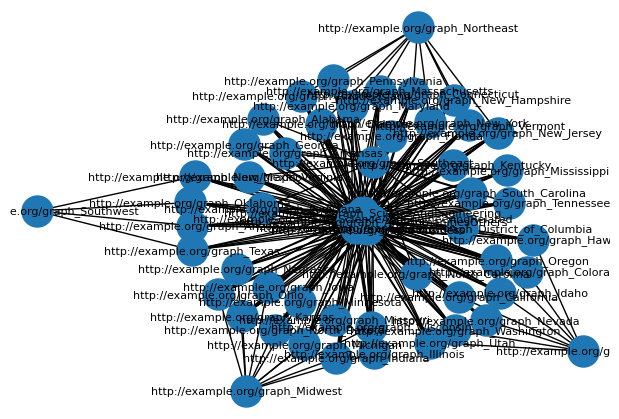

In [255]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a NetworkX graph from the RDF graph
nx_graph = nx.Graph()

for s, p, o in graph:
    nx_graph.add_node(s)
    nx_graph.add_node(o)
    nx_graph.add_edge(s, o)

# Visualize the graph
pos = nx.spring_layout(nx_graph)  # Layout the nodes using the spring layout algorithm
nx.draw(nx_graph, pos, with_labels=True, node_size=500, font_size=8)
plt.show()

In [262]:
graph.serialize(destination='output.xml', format='xml')

<Graph identifier=N219b3c1eab53479fb2884b0d4dc1d54f (<class 'rdflib.graph.Graph'>)>